# train ([tflm-hello-world](https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/examples/hello_world))


In [80]:
import math
import os

from absl import app
from absl import flags
from absl import logging
import numpy as np
import tensorflow as tf

def get_data():

  x_values = np.random.uniform(low=0, high=2 * math.pi,size=3000).astype(np.float32)

  np.random.shuffle(x_values)

  y_values = np.sin(x_values).astype(np.float32)

  return (x_values, y_values)

In [81]:
def create_model(hidden_layer , hidden_dim) -> tf.keras.Model:
  model = tf.keras.Sequential()

  for i in range(hidden_layer):
    if i == 0:
      model.add(tf.keras.layers.Dense(hidden_dim, activation='relu', input_shape=(1, )))
    else:
      model.add(tf.keras.layers.Dense(hidden_dim, activation='relu'))


  model.add(tf.keras.layers.Dense(1))

  model.compile(optimizer='adam', loss='mse', metrics=['mae'])

  return model

In [82]:
def convert_tflite_model(model):

  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  tflite_model = converter.convert()
  return tflite_model


In [83]:
def convert_quant_tflite_model(model , x_values):
  def representative_dataset(num_samples=500):
    for i in range(num_samples):
      yield [x_values[i].reshape(1, 1)]

  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  # tflite_model = converter.convert()
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
  converter.inference_input_type = tf.int8
  converter.inference_output_type = tf.int8
  converter.representative_dataset = representative_dataset
  tflite_model = converter.convert()

  return tflite_model

In [84]:
def save_tflite_model(tflite_model, save_dir, model_name):

  if not os.path.exists(save_dir):
    os.makedirs(save_dir)
  save_path = os.path.join(save_dir, model_name)
  with open(save_path, "wb") as f:
    f.write(tflite_model)
  logging.info("Tflite model saved to %s", save_dir)

In [85]:
def train_model(epochs, hidden_layer , hidden_dim, x_values, y_values):

  model = create_model(hidden_layer,hidden_dim)
  model.fit(x_values,
            y_values,
            epochs=epochs,
            validation_split=0.1,
            batch_size=128,
            verbose=2)

  return model

## hyperparameter
set the epoch & hidden layer & hidden dim variable


In [86]:
hidden_layer = 4
hidden_dim = 16
epoch = 100

In [87]:
x_values, y_values = get_data()
trained_model = train_model(epoch, hidden_layer, hidden_dim, x_values, y_values)
# Convert and save the model to .tflite
tflite_model = convert_tflite_model(trained_model)
save_tflite_model(tflite_model,"./",model_name="hello_world_float.tflite")
tflite_quant_model = convert_quant_tflite_model(trained_model , x_values)
# Convert full int8 and save the model to quant.tflite
save_tflite_model(tflite_quant_model,"./",model_name="hello_world_quant.tflite")


Epoch 1/100
22/22 - 2s - loss: 0.4197 - mae: 0.5629 - val_loss: 0.3426 - val_mae: 0.4876 - 2s/epoch - 80ms/step
Epoch 2/100
22/22 - 0s - loss: 0.3467 - mae: 0.5095 - val_loss: 0.2860 - val_mae: 0.4551 - 127ms/epoch - 6ms/step
Epoch 3/100
22/22 - 0s - loss: 0.2939 - mae: 0.4703 - val_loss: 0.2362 - val_mae: 0.4187 - 108ms/epoch - 5ms/step
Epoch 4/100
22/22 - 0s - loss: 0.2265 - mae: 0.4176 - val_loss: 0.1763 - val_mae: 0.3617 - 130ms/epoch - 6ms/step
Epoch 5/100
22/22 - 0s - loss: 0.1625 - mae: 0.3526 - val_loss: 0.1358 - val_mae: 0.3120 - 118ms/epoch - 5ms/step
Epoch 6/100
22/22 - 0s - loss: 0.1251 - mae: 0.2976 - val_loss: 0.1068 - val_mae: 0.2574 - 109ms/epoch - 5ms/step
Epoch 7/100
22/22 - 0s - loss: 0.1010 - mae: 0.2464 - val_loss: 0.0938 - val_mae: 0.2194 - 122ms/epoch - 6ms/step
Epoch 8/100
22/22 - 0s - loss: 0.0896 - mae: 0.2172 - val_loss: 0.0868 - val_mae: 0.2021 - 74ms/epoch - 3ms/step
Epoch 9/100
22/22 - 0s - loss: 0.0833 - mae: 0.1992 - val_loss: 0.0822 - val_mae: 0.1981 - 

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


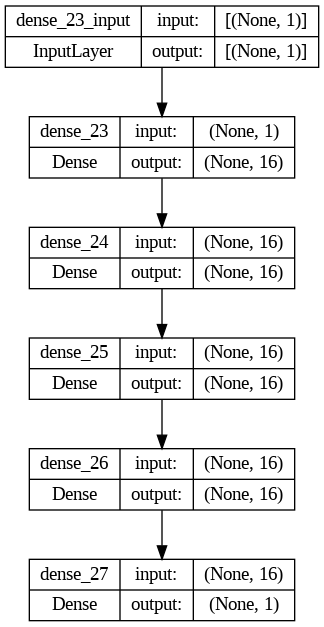

In [88]:
tf.keras.utils.plot_model(trained_model , show_shapes=True)

# test

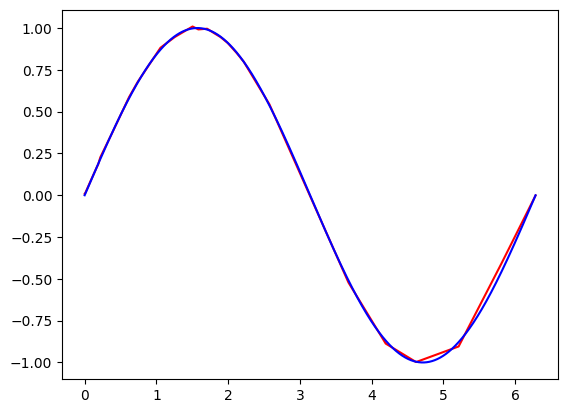

In [89]:
import matplotlib.pyplot as plt

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input = interpreter.get_input_details()[0]
output = interpreter.get_output_details()[0]

in_data = np.arange(0,2*math.pi,0.001)
out_data = []
real_out = []
for _ in in_data:
  interpreter.set_tensor(input['index'], np.array([[_]],dtype=np.float32))
  interpreter.invoke()
  out_data.append(interpreter.get_tensor(output['index'])[0][0])
  real_out.append(math.sin(_))
# print(output)
plt.plot(in_data, out_data, 'r')
plt.plot(in_data, real_out, 'b')
plt.show()

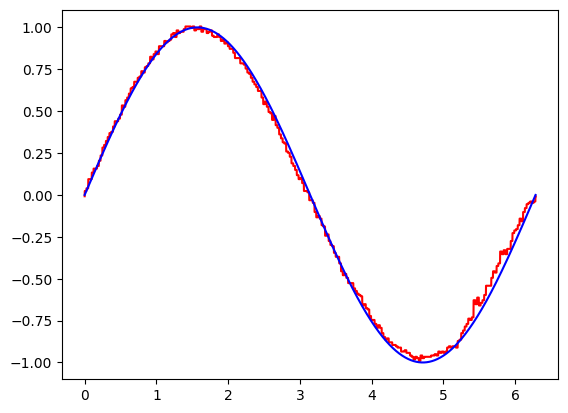

In [90]:
import matplotlib.pyplot as plt

interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

input = interpreter.get_input_details()[0]
output = interpreter.get_output_details()[0]
input_scale, input_zero_point = input["quantization"]
output_scale, output_zero_point = output["quantization"]

in_data = np.arange(0,2*math.pi,0.001)
out_data = []
real_out = []
for _ in in_data:
  quant_ = _ / input_scale + input_zero_point
  interpreter.set_tensor(input['index'], np.array([[quant_]],dtype=np.int8))
  interpreter.invoke()
  dequant_ = (interpreter.get_tensor(output['index'])[0][0] - output_zero_point) * output_scale
  out_data.append(dequant_)
  real_out.append(math.sin(_))
# # print(output)
plt.plot(in_data, out_data, 'r')
plt.plot(in_data, real_out, 'b')
plt.show()

# hello world lab

In [ ]:
!git clone https://github.com/Yui-Arthur/tinyML_TFLM_lab.git

Cloning into 'tinyML_TFLM_lab'...
remote: Enumerating objects: 730, done.
remote: Counting objects: 100% (730/730), done.
remote: Compressing objects: 100% (475/475), done.
remote: Total 730 (delta 271), reused 697 (delta 238), pack-reused 0
Receiving objects: 100% (730/730), 4.62 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (271/271), done.


In [ ]:
%cd tinyML_TFLM_lab/hello_world_lab/hello_world

/content/tinyML_TFLM_lab/hello_world_lab/hello_world


## run script

In [ ]:
# setup the tflm lib
# -c tag to download with CMSIS
# https://github.com/ARM-software/ML-examples/blob/main/tflm-cmsisnn-mbed-image-recognition/setup.sh
!bash setup.sh
# !bash setup.sh -c

# change flatbuffers header to fb_*
# https://github.com/tensorflow/tflite-micro/issues/1226
!bash preprocess.sh


Cloning into 'tflite-micro'...
remote: Enumerating objects: 18832, done.
remote: Counting objects: 100% (18832/18832), done.
remote: Compressing objects: 100% (5040/5040), done.
remote: Total 18832 (delta 13565), reused 18603 (delta 13470), pack-reused 0
Receiving objects: 100% (18832/18832), 30.55 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (13565/13565), done.
--2023-11-08 14:02:52--  https://github.com/google/flatbuffers/archive/v23.5.26.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/google/flatbuffers/zip/refs/tags/v23.5.26 [following]
--2023-11-08 14:02:52--  https://codeload.github.com/google/flatbuffers/zip/refs/tags/v23.5.26
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting res

## export .tflite model to .cc

In [ ]:
!xxd -i /content/hello_world_float.tflite > model.cc
!echo -ne "#include \"model_data.h\"\nalignas(8)\n" > model_data.cc
!cat model.cc >> model_data.cc
!sed -i -E 's/(unsigned\s.*\s).*(_len|\[\])/const \1model_data\2/g' model_data.cc

In [ ]:
!xxd -i /content/hello_world_quant.tflite > model.cc
!echo -ne "#include \"model_data_quant.h\"\nalignas(8)\n" > model_data_quant.cc
!cat model.cc >> model_data_quant.cc
!sed -i -E 's/(unsigned\s.*\s).*(_len|\[\])/const \1model_data_quant\2/g' model_data_quant.cc

## compile


In [ ]:
!sudo apt-get install python3.7
!sudo apt-get update -y
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --config python3 << '2'
!sudo apt install python3-pip
!sudo apt-get install python3.7-distutils
!python -m pip install --upgrade --force-reinstall pip

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support
  python3.7-minimal
Suggested packages:
  python3.7-venv binfmt-support
The following NEW packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7
  python3.7-minimal
0 upgraded, 6 newly installed, 0 to remove and 19 not upgraded.
Need to get 4,698 kB of archives.
After this operation, 17.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:2 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.7-minimal amd64 3.7.17-1+jammy1 [608 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 mime-support all 3.66 [3,696 B]
Get:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.7-minima

In [ ]:
!python -V
!pip -V

Python 3.7.17
pip 23.3.1 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


In [ ]:
!sudo apt install git mercurial libusb-1.0-0-dev
!pip install mbed-cli
# install python dependency

!wget https://raw.githubusercontent.com/ARMmbed/mbed-os/master/requirements.txt
!sed -i 's/psutil==5.6.7/ /' requirements.txt
!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
The following additional packages will be installed:
  libusb-1.0-doc mercurial-common
Suggested packages:
  kdiff3 | kdiff3-qt | kompare | meld | tkcvs | mgdiff qct python3-mysqldb
  python3-openssl python3-pygments
The following NEW packages will be installed:
  libusb-1.0-0-dev libusb-1.0-doc mercurial mercurial-common
0 upgraded, 4 newly installed, 0 to remove and 28 not upgraded.
Need to get 3,485 kB of archives.
After this operation, 17.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libusb-1.0-0-dev amd64 2:1.0.25-1ubuntu2 [76.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libusb-1.0-doc all 2:1.0.25-1ubuntu2 [183 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mercurial-common all 6.1.1-1ubuntu1 [2,906 kB]
Get:4 http://archive.u

--2023-11-08 14:04:25--  https://raw.githubusercontent.com/ARMmbed/mbed-os/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 591 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     591  --.-KB/s    in 0s      

2023-11-08 14:04:25 (32.4 MB/s) - ‘requirements.txt’ saved [591/591]

Ignoring hidapi: markers 'platform_system != "Linux"' don't match your environment
Ignoring pywin32: markers 'platform_system == "Windows"' don't match your environment
Ignoring wmi: markers 'platform_system == "Windows"' don't match your environment
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.

In [ ]:
!wget -O gcc-arm-none-eabi-9-2020-q2-update-x86_64-linux.tar.bz2 https://developer.arm.com/-/media/Files/downloads/gnu-rm/9-2020q2/gcc-arm-none-eabi-9-2020-q2-update-x86_64-linux.tar.bz2?revision=05382cca-1721-44e1-ae19-1e7c3dc96118&rev=05382cca172144e1ae191e7c3dc96118&hash=FDE675133A099796BD1507A3FF215AC4
!sudo tar -jxvf ./gcc-arm-none-eabi-9-2020-q2-update-x86_64-linux.tar.bz2 -C /usr/local/

串流輸出內容已截斷至最後 5000 行。
gcc-arm-none-eabi-9-2020-q2-update/arm-none-eabi/include/c++/9.3.1/arm-none-eabi/thumb/v7-a/nofp/ext/opt_random.h
gcc-arm-none-eabi-9-2020-q2-update/arm-none-eabi/include/c++/9.3.1/arm-none-eabi/thumb/v7-a/nofp/bits/
gcc-arm-none-eabi-9-2020-q2-update/arm-none-eabi/include/c++/9.3.1/arm-none-eabi/thumb/v7-a/nofp/bits/c++locale.h
gcc-arm-none-eabi-9-2020-q2-update/arm-none-eabi/include/c++/9.3.1/arm-none-eabi/thumb/v7-a/nofp/bits/os_defines.h
gcc-arm-none-eabi-9-2020-q2-update/arm-none-eabi/include/c++/9.3.1/arm-none-eabi/thumb/v7-a/nofp/bits/cxxabi_tweaks.h
gcc-arm-none-eabi-9-2020-q2-update/arm-none-eabi/include/c++/9.3.1/arm-none-eabi/thumb/v7-a/nofp/bits/time_members.h
gcc-arm-none-eabi-9-2020-q2-update/arm-none-eabi/include/c++/9.3.1/arm-none-eabi/thumb/v7-a/nofp/bits/c++io.h
gcc-arm-none-eabi-9-2020-q2-update/arm-none-eabi/include/c++/9.3.1/arm-none-eabi/thumb/v7-a/nofp/bits/extc++.h
gcc-arm-none-eabi-9-2020-q2-update/arm-none-eabi/include/c++/9.3.1/arm-none-e

In [ ]:
!pip install psutil
!pip install Jinja2
!pip install jsonschema
!pip install Pillow
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.6/283.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 32.7 MB/s eta 0:00:00


In [ ]:
!mbed config -G GCC_ARM_PATH /usr/local/gcc-arm-none-eabi-9-2020-q2-update/bin
!mbed config -G TOOLCHAIN GCC_ARM
!mbed add mbed-os
!mbed deploy

[mbed] /usr/local/gcc-arm-none-eabi-9-2020-q2-update/bin now set as global GCC_ARM_PATH
[mbed] GCC_ARM now set as global TOOLCHAIN
[mbed] Working path "/content/tinyML_TFLM_lab/hello_world_lab/hello_world" (library)
[mbed] Program path "/content/tinyML_TFLM_lab/hello_world_lab/hello_world"
[mbed] WARNING: Program "hello_world" in "/content/tinyML_TFLM_lab/hello_world_lab/hello_world" does not use source control management.
       To fix this you should use "mbed new ." in the root of your program.
---
[mbed] Adding library "mbed-os" from "https://github.com/ARMmbed/mbed-os" at latest revision in the current branch
[mbed] Updating reference "mbed-os" -> "https://github.com/ARMmbed/mbed-os/#72f27cee92a4bdafa30513f732e007ba635dc93f"
[mbed] Working path "/content/tinyML_TFLM_lab/hello_world_lab/hello_world" (library)
[mbed] Program path "/content/tinyML_TFLM_lab/hello_world_lab/hello_world"
[mbed] WARNING: Program "hello_world" in "/content/tinyML_TFLM_lab/hello_world_lab/hello_world" does

In [ ]:
!sudo mbed compile

[mbed] Working path "/content/tinyML_TFLM_lab/hello_world_lab/hello_world" (library)
[mbed] Program path "/content/tinyML_TFLM_lab/hello_world_lab/hello_world"
Building project hello_world (NUCLEO_F767ZI, GCC_ARM)
Scan: hello_world
Compile [ 99.8%]: model.cc
Compile [100.0%]: model_data.cc
Link: hello_world
Elf2Bin: hello_world
| Module             |     .text |    .data |     .bss |
|--------------------|-----------|----------|----------|
| [fill]             |   124(+0) |    4(+0) |   18(+0) |
| [lib]/c.a          | 12468(+0) | 2472(+0) |   89(+0) |
| [lib]/gcc.a        |  3232(+0) |    0(+0) |    0(+0) |
| [lib]/m.a          |  3564(+0) |    0(+0) |    0(+0) |
| [lib]/misc         |   188(+0) |    4(+0) |   28(+0) |
| [lib]/nosys.a      |    32(+0) |    0(+0) |    0(+0) |
| hello_world.o      |  1120(+0) |    0(+0) |    0(+0) |
| mbed-os/drivers    |   474(+0) |    0(+0) |    0(+0) |
| mbed-os/hal        |  1236(+0) |    4(+0) |   58(+0) |
| mbed-os/platform   |  4824(+0) |  260(+0)